# scraper Monster
*********************

In [1]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import datetime
import qgrid
 
 
 
Scrap_Monster = {"Categorie":[],
                 "intitule de l'offre": [],
                 "nom_entreprise": [],
                 "lieu": [],
                 "DATE": [],
                 "lien": [],
                 "latitude":[],
                 "longitude":[],
                 "description":[],
                 "Type-contrat":[],
                 "langage_prog":[],
                 "langage2":[],
                 "langage3":[],
                 "langage4":[] }  
 
list_clefs = ["data-analyst", "data-scientist", "developpeur-data", "data-ingenieur"]


for mot_clef in list_clefs:
    url_sc_monster = f'https://www.monster.fr/emploi/recherche/?q={mot_clef}&where=Auvergne__2DRh__C3__B4ne__2DAlpes&cy=fr&stpage=1&page=9'  
    r = requests.get(url_sc_monster, auth=('user', 'pass'))
    r.status_code
    r.headers['content-type']
    soup = bs(r.text, 'html.parser')
    sc_intitule = soup.find_all("h2", class_ = "title")
    sc_nom_entreprise= soup.find_all("div", class_ = "company")
    sc_lien = soup.find_all("h2", class_ = "title")
    sc_lieu = soup.find_all("div", class_ = "location")
    sc_autre_lieu = soup.find_all("span", class_ = "mux-tooltip multi-loc-link")
    sc_coord =soup.find_all('a',{"data-bypass":"true"})
    for i in range(len(soup.find_all("div", {"class":"summary"}))-1):
        Scrap_Monster["Categorie"].append(mot_clef)
        Scrap_Monster["intitule de l'offre"].append(sc_intitule[i].text.replace("\n", "").strip())        
        Scrap_Monster["lien"].append(sc_lien[i].find('a').get('href'))      
        Scrap_Monster["nom_entreprise"].append(sc_nom_entreprise[i].text.replace("\n", " ").strip())      
        Scrap_Monster["lieu"].append(sc_lieu[i+1].text.replace("\n", "").strip().replace(", Auvergne-Rhône-Alpes", " "))
        Scrap_Monster['latitude'].append(str(sc_coord[i].get('data-m_impr_j_lat')))
        Scrap_Monster['longitude'].append(str(sc_coord[i].get('data-m_impr_j_long')))
        regex = re.compile("\d{4}-\d{2}-\d{2}")
        date = regex.findall(str(sc_coord[i]))
        Scrap_Monster["DATE"].append(date[0] if len(date)>0 else np.nan)
        url_offre = sc_lien[i].find('a').get('href')
        r = requests.get(url_offre)
        soupet = bs(r.text, 'html.parser')
        sc_description_raw = soupet.find("div", class_ = "job-description")
        if  sc_description_raw is None:
            Scrap_Monster["description"].append(None)
        else:
            sc_description = sc_description_raw.text
            Scrap_Monster["description"].append(sc_description)
        regex = re.compile("((CDI)|(CDD)|(stage))")
        type_contrat = re.findall(regex, str(Scrap_Monster["description"][i]))
        if len(type_contrat)>0:
            Scrap_Monster["Type-contrat"].append(list(type_contrat)[0][0])
        else:
            Scrap_Monster["Type-contrat"].append(np.nan)
        pattern1 = re.compile(r'(?P<sql>[Ss][Qq][Ll])')
        pattern2 = re.compile(r'(?P<python>[Pp][Yy][Tt][Hh][Oo][Nn])')
        pattern3 = re.compile(r'(?P<scala>[Ss][Cc][Aa][Ll][Aa])')
        pattern4 = re.compile(r'(?P<java>[Jj][Aa][Vv][Aa])')
        match1 = re.search(pattern1,sc_description)
        match2 = re.search(pattern2,sc_description)
        match3 = re.search(pattern3,sc_description)
        match4 = re.search(pattern4,sc_description)
        if match1 is None:
            Scrap_Monster["langage_prog"].append(np.nan)    
        else:
            Scrap_Monster["langage_prog"].append(match1.group())
        if match2 is None:
            Scrap_Monster["langage2"].append(np.nan)
            
        else:  
            Scrap_Monster["langage2"].append(match2.group())    
        if match3 is None:
            Scrap_Monster["langage3"].append(np.nan)
        else:    
            Scrap_Monster["langage3"].append(match3.group())
        if match4 is None:
            Scrap_Monster["langage4"].append(np.nan)
        else:  
            Scrap_Monster["langage4"].append(match4.group())
            


## Qgrid
***********

In [25]:
import qgrid

def grid_m():
    df1 = pd.DataFrame(Scrap_Monster)
    for row in df1.iterrows():
        row[1]['langage_prog']=str(row[1]['langage_prog'])+", "+str(row[1]['langage2'])+", "+str(row[1]['langage3'])+", "+str(row[1]['langage4'])
    df1.to_csv('monster.csv', index=False)
    df = df1.drop(["langage4", "langage2", "langage3", "description", "longitude", "latitude"], axis = 1)
    df["langage_prog"].replace('nan', 'oui')
    df_qgrid = qgrid.show_grid(df, show_toolbar=True)
    return df_qgrid
    
grid_m()

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [17]:
df1

NameError: name 'df1' is not defined

## figure matplotlib

#### * Par métier de la Data
**************************************

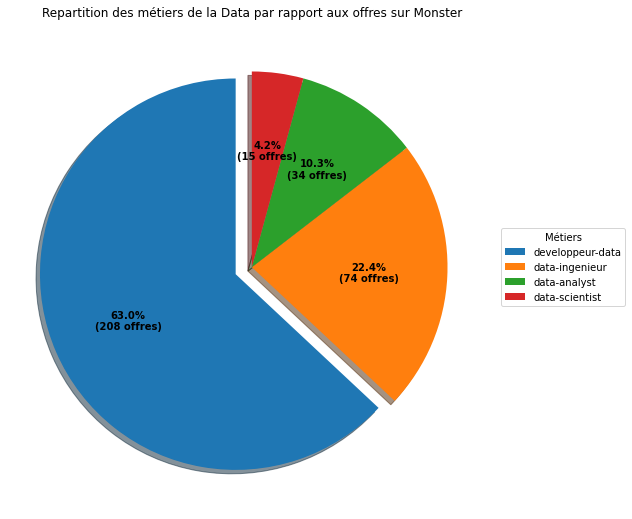

In [52]:
def job_m():
    
    df = pd.read_csv('monster.csv')
    
    fig, ax = plt.subplots(figsize=(15, 9), subplot_kw=dict(aspect="equal"))
    cat = df["Categorie"].value_counts()
    cat = cat.astype(str)
    data = [float(x.split()[0]) for x in cat]
    Métiers =["developpeur-data", "data-ingenieur", "data-analyst", "data-scientist"]
    
    def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals) + 1)
        return "{:.1f}%\n({:d} offres)".format(pct, absolute)
    
    explode=(0.09, 0, 0, 0)
    wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),explode=explode, shadow=True, startangle=90, textprops=dict(color="black"))
    ax.legend(wedges, Métiers,
              title="Métiers",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size=10, weight="bold")

    ax.set_title("Repartition des métiers de la Data par rapport aux offres sur Monster")

    return plt.show()
    
job_m()

In [ ]:
df =  pd.read_csv("monster.csv")
label = df.groupby(df.iloc[:,0])
label

### * Par type de contrat
**************************************************

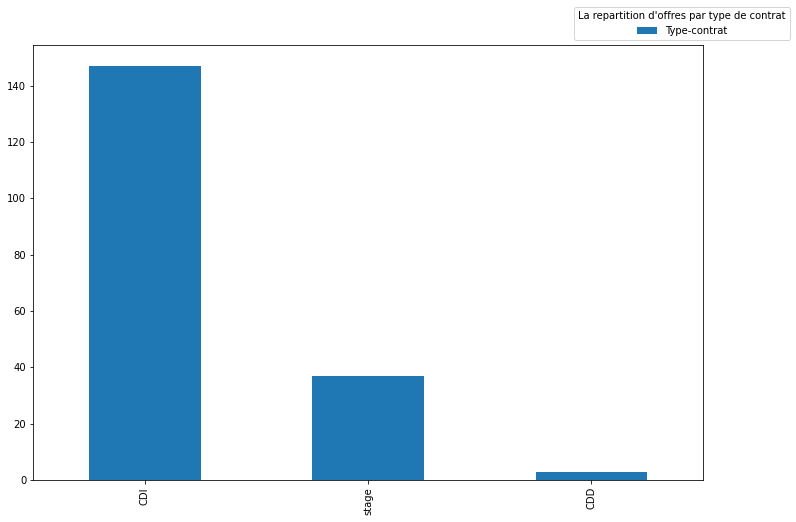

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

def contrat():
    data =  pd.read_csv("monster.csv")
    cat = data["Type-contrat"].value_counts()
    cat.plot(kind="bar",stacked=True,figsize=(12,8))
    plt.legend(title = "La repartition d'offres par type de contrat", loc="lower left",bbox_to_anchor=(0.8,1.0))
    return 
contrat()

# Folium (localisation des  offres du site monster)
*******

In [1]:
import random
import folium
from folium.plugins import MarkerCluster
import pandas as pd

def maps():
    long = 5.4502821
    lat = 45.1695797
    ARA = (lat, long)
    carte = folium.Map(location=ARA, zoom_start=9, tiles='OpenStreetMap')
    marker_cluster = MarkerCluster().add_to(carte)
    offres = pd.read_csv("monster.csv")
    df = offres.fillna(0)
    for i , row in df.iterrows():
        folium.Marker(location = [row['latitude'], row['longitude']], popup = (row["lien"], row["Categorie"],row["Type-contrat"])).add_to(marker_cluster)

    marker_cluster.add_to(carte)

    folium.LayerControl().add_to(carte) 
    return carte

maps()